In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from more_itertools import consecutive_groups
import dask
import dask.array as da
import matplotlib.pyplot as plt
from numba import jit, prange
import warnings

In [ ]:
# Claude code that diverges slightly as kbdi begins to decrease

@jit(nopython=True)
def _calc_pnet_consecutive_numba(pr_data, cat_data, acc_thresh=0.2):
    """Numba-optimized function to calculate Pnet for consecutive rain days."""
    pnet = pr_data.copy()
    n_time = len(pr_data)
    
    # Find consecutive rain day indices
    consec_inds = []
    for i in range(n_time):
        if cat_data[i] == 2:
            consec_inds.append(i)
    
    if len(consec_inds) == 0:
        return pnet
    
    # Process consecutive rain events
    i = 0
    while i < len(consec_inds):
        # Find the end of current consecutive event
        event_start = i
        while i < len(consec_inds) - 1 and consec_inds[i+1] == consec_inds[i] + 1:
            i += 1
        event_end = i
        
        # Process this consecutive rain event
        accpr = 0.0
        thresh_flag = False
        
        for j in range(event_start, event_end + 1):
            ind = consec_inds[j]
            accpr += pr_data[ind]
            
            if accpr <= acc_thresh and not thresh_flag:
                pnet[ind] = 0.0
            elif accpr > acc_thresh and not thresh_flag:
                accpr -= acc_thresh
                pnet[ind] = accpr
                thresh_flag = True
            else:
                pnet[ind] = pr_data[ind]
        
        i += 1
    
    return pnet

@jit(nopython=True)
def _calc_kbdi_timeseries_numba(T_data, pnet_data, mean_ann_pr, day_int):
    """Numba-optimized KBDI time series calculation."""
    n_time = len(T_data)
    KBDI = np.full(n_time, np.nan)
    
    if day_int >= 0 and day_int < n_time:
        KBDI[day_int] = 0.0
        
        denominator = 1 + 10.88 * np.exp(-0.0441 * mean_ann_pr)
        
        for it in range(day_int + 1, n_time):
            Q = max(0.0, KBDI[it-1] - pnet_data[it] * 100)
            numerator = (800 - Q) * (0.968 * np.exp(0.0486 * T_data[it]) - 8.3)
            KBDI[it] = Q + (numerator / denominator) * 1e-3
    
    return KBDI

def calc_kbdi_vectorized(T, PR):
    """
    Vectorized KBDI calculation for multiple grid points.
    
    Parameters:
    -----------
    T : xarray.DataArray
        Temperature data with dimensions (time, lat, lon) in Fahrenheit
    PR : xarray.DataArray  
        Precipitation data with dimensions (time, lat, lon) in inches
    
    Returns:
    --------
    KBDI : xarray.DataArray
        KBDI values with same dimensions as input
    """
    
    # Create land mask - only calculate where we have finite precipitation
    landmask = np.isfinite(PR.mean('time'))
    
    # Create time index
    time_index = np.arange(len(PR.time)).astype('int')
    PR = PR.assign_coords(time_index=('time', time_index))
    T = T.assign_coords(time_index=('time', time_index))
    
    # Parameters
    ndays = 7
    pr_thresh = 8  # inches
    acc_thresh = 0.2  # inches
    
    # Calculate 7-day rolling precipitation sum
    pr_weeksum = PR.rolling(time=ndays, min_periods=ndays, center=False).sum()
    
    # Find saturation days (vectorized across space)
    def find_first_saturation_day(pr_week_1d):
        """Find first day where weekly precip exceeds threshold."""
        if np.isnan(pr_week_1d).all():
            return -1
        
        exceeds = pr_week_1d > pr_thresh
        if not exceeds.any():
            return -1
        
        return int(np.argmax(exceeds))
    
    # Apply across lat/lon dimensions
    saturation_days = xr.apply_ufunc(
        find_first_saturation_day,
        pr_weeksum,
        input_core_dims=[['time']],
        output_dtypes=[int],
        vectorize=True,
        dask='parallelized'
    )
    
    # Calculate consecutive rain days (vectorized)
    rainmask = xr.where(PR > 0, 1, 0)
    rr = rainmask.cumsum(dim='time') - rainmask.cumsum(dim='time').where(rainmask == 0).ffill(dim='time').fillna(0)
    
    # Categorize rainfall days vectorized
    rr_swap = rr.swap_dims({'time': 'time_index'})
    cat = xr.where(rr_swap >= 3, 5, rr_swap)
    
    # Find consecutive day patterns (vectorized)
    consec_day2_mask = (rr_swap == 2)
    consec_day1_mask = consec_day2_mask.shift(time_index=1, fill_value=False)
    consec_day3plus_mask = (rr_swap >= 3)
    
    cat = xr.where(consec_day1_mask | consec_day2_mask | consec_day3plus_mask, 2, cat)
    cat = xr.where(cat == 5, 2, cat)
    
    # Calculate mean annual precipitation
    years = pd.to_datetime(PR.time.values).year
    PR_with_year = PR.assign_coords(year=('time', years))
    annual_sums = PR_with_year.groupby('year').sum(min_count=360)
    mean_ann_pr = annual_sums.mean('year')
    
    # Initialize Pnet
    pnet = PR.swap_dims({'time': 'time_index'}).copy()
    
    # Category 1 (single rain days) - vectorized
    single_rain_mask = (cat == 1)
    pnet = xr.where(single_rain_mask, pnet - acc_thresh, pnet)
    pnet = xr.where(pnet < 0, 0, pnet)
    
    # Define function to process a single grid point
    def process_single_point(pr_1d, t_1d, cat_1d, mean_ann_pr_val, sat_day):
        """Process KBDI for a single lat/lon point."""
        if np.isnan(mean_ann_pr_val) or sat_day < 0:
            return np.full(len(pr_1d), np.nan)
        
        # Calculate Pnet for consecutive rain days
        pnet_1d = _calc_pnet_consecutive_numba(
            pr_1d.astype(np.float64), 
            cat_1d.astype(np.int32), 
            acc_thresh
        )
        
        # Apply single rain day adjustment
        single_mask = (cat_1d == 1)
        pnet_1d = np.where(single_mask, np.maximum(0, pnet_1d - acc_thresh), pnet_1d)
        
        # Calculate KBDI time series
        kbdi_1d = _calc_kbdi_timeseries_numba(
            t_1d.astype(np.float64),
            pnet_1d.astype(np.float64),
            float(mean_ann_pr_val),
            int(sat_day)
        )
        
        return kbdi_1d
    
    # Apply the function across all grid points
    KBDI = xr.apply_ufunc(
        process_single_point,
        PR.swap_dims({'time': 'time_index'}),
        T.swap_dims({'time': 'time_index'}),
        cat,
        mean_ann_pr,
        saturation_days,
        input_core_dims=[['time_index'], ['time_index'], ['time_index'], [], []],
        output_core_dims=[['time_index']],
        output_dtypes=[float],
        vectorize=True,
        dask='parallelized'
    )
    
    # Convert back to original time coordinate
    KBDI = KBDI.swap_dims({'time_index': 'time'})
    KBDI = KBDI.assign_coords(time=PR.time)
    
    return KBDI

def calc_kbdi_parallel_chunked(T, PR, chunks=None):
    """
    Parallel chunked version of KBDI calculation using Dask.
    
    Parameters:
    -----------
    T : xarray.DataArray
        Temperature data with dimensions (time, lat, lon) - will be converted to Fahrenheit
    PR : xarray.DataArray  
        Precipitation data with dimensions (time, lat, lon) - will be converted to inches
    chunks : dict, optional
        Chunk sizes for dask arrays, e.g., {'lat': 10, 'lon': 10, 'time': -1}
    
    Returns:
    --------
    KBDI : xarray.DataArray
        KBDI values with same dimensions as input
    """
    
    if chunks is None:
        # Default chunking strategy
        chunks = {'lat': min(20, T.sizes['lat']), 
                  'lon': min(20, T.sizes['lon']), 
                  'time': -1}  # Keep time together
    
    # Chunk the input data FIRST
    T_chunked = T.chunk(chunks)
    PR_chunked = PR.chunk(chunks)
    
    # THEN apply unit conversions (done in parallel by Dask)
    T_chunked = (T_chunked * 9/5) + 32  # Convert to Fahrenheit
    T_chunked.attrs = {'standard_name': 'air_temperature',
                       'long_name': 'Temperature, daily maximum',
                       'units': 'F'}
    
    PR_chunked = PR_chunked / 25.4  # Convert to inches
    PR_chunked.attrs = {'standard_name': 'precipitation', 
                        'long_name': 'Precipitation, daily total', 
                        'units': 'inches/day'}
    
    # Apply the vectorized calculation
    KBDI = calc_kbdi_vectorized(T_chunked, PR_chunked)
    
    return KBDI

# Example usage function
def example_usage():
    """
    Example of how to use the optimized KBDI calculation.
    """
    
    # Load your data (replace with your actual file paths)
    # pr_file = 'your_precip_file.nc'
    # tmax_file = 'your_temp_file.nc'
    
    year_start = '1951'
    year_end = '2024'
    
    # Load the full spatial domain you want to process
    # DON'T do unit conversions yet - let Dask handle them in parallel
    
    # pr = xr.open_dataset(pr_file).prcp.sel(time=slice(year_start, year_end))
    # tmax = xr.open_dataset(tmax_file).tmax.sel(time=slice(year_start, year_end))
    
    # # Define chunk sizes based on your memory constraints
    # chunks = {'lat': 20, 'lon': 20, 'time': -1}
    
    # # Chunk the data first
    # pr_chunked = pr.chunk(chunks)
    # tmax_chunked = tmax.chunk(chunks)
    
    # # THEN apply unit conversions (this will be done in parallel by Dask)
    # pr_chunked = pr_chunked / 25.4  # Convert to inches
    # pr_chunked.attrs = {'standard_name': 'precipitation', 
    #                     'long_name': 'Precipitation, daily total', 
    #                     'units': 'inches/day'}
    
    # tmax_chunked = (tmax_chunked * 9/5) + 32  # Convert to Fahrenheit
    # tmax_chunked.attrs = {'standard_name': 'air_temperature',
    #                       'long_name': 'Temperature, daily maximum',
    #                       'units': 'F'}
    
    # # Method 1: Simple vectorized approach (for smaller datasets)
    # kbdi_result = calc_kbdi_vectorized(tmax_chunked, pr_chunked)
    
    # # Method 2: Parallel chunked approach (recommended - automatically handles chunking)
    # kbdi_result = calc_kbdi_parallel_chunked(tmax, pr, chunks=chunks)
    
    # # Compute results (for dask arrays)
    # kbdi_result = kbdi_result.compute()
    
    # # Save results
    # kbdi_result.to_netcdf('kbdi_results.nc')
    
    print("Example usage function - replace with your actual file paths and parameters")

# if __name__ == "__main__":
#     example_usage()

In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
from more_itertools import consecutive_groups
import dask
import dask.array as da
import matplotlib.pyplot as plt
from numba import jit, prange
import warnings

@jit(nopython=True)
def _calc_pnet_consecutive_numba(pr_data, cat_data, acc_thresh=0.2, pnet_data=None):
    """Numba-optimized function to calculate Pnet for consecutive rain days."""
    if pnet_data is None:
        pnet = pr_data.copy()
    else:
        pnet = pnet_data.copy()
    
    n_time = len(pr_data)
    
    # Find consecutive rain day indices
    consec_inds = []
    for i in range(n_time):
        if cat_data[i] == 2:
            consec_inds.append(i)
    
    if len(consec_inds) == 0:
        return pnet
    
    # Process consecutive rain events
    i = 0
    while i < len(consec_inds):
        # Find the end of current consecutive event
        event_start = i
        while i < len(consec_inds) - 1 and consec_inds[i+1] == consec_inds[i] + 1:
            i += 1
        event_end = i
        
        # Process this consecutive rain event - exactly match original logic
        accpr = 0.0
        thresh_flag = False
        
        for j in range(event_start, event_end + 1):
            ind = consec_inds[j]
            # Accumulate precip per rain event
            accpr += pr_data[ind]
            
            # if not over the threshold yet, Pnet is 0
            if accpr <= acc_thresh and not thresh_flag:
                pnet[ind] = 0.0
            # on the day the threshold is met, subtract the threshold amount and change flag
            elif accpr > acc_thresh and not thresh_flag:
                accpr = accpr - acc_thresh  # accumulate precip and subtract threshold
                pnet[ind] = accpr
                thresh_flag = True
            # any days after the threshold is met, precip will remain unchanged
            else:
                pnet[ind] = pr_data[ind]
        
        i += 1
    
    return pnet

@jit(nopython=True)
def _calc_kbdi_timeseries_numba(T_data, pnet_data, mean_ann_pr, day_int):
    """Numba-optimized KBDI time series calculation."""
    n_time = len(T_data)
    KBDI = np.full(n_time, np.nan)
    
    if day_int >= 0 and day_int < n_time:
        KBDI[day_int] = 0.0
        
        denominator = 1 + 10.88 * np.exp(-0.0441 * mean_ann_pr)
        
        for it in range(day_int + 1, n_time):
            Q = max(0.0, KBDI[it-1] - pnet_data[it] * 100)
            numerator = (800 - Q) * (0.968 * np.exp(0.0486 * T_data[it]) - 8.3)
            KBDI[it] = Q + (numerator / denominator) * 1e-3
    
    return KBDI

def calc_kbdi_vectorized(T, PR, debug_lat=None, debug_lon=None, debug_time_slice=None):
    """
    Vectorized KBDI calculation for multiple grid points.
    
    Parameters:
    -----------
    T : xarray.DataArray
        Temperature data with dimensions (time, lat, lon) in Fahrenheit
    PR : xarray.DataArray  
        Precipitation data with dimensions (time, lat, lon) in inches
    debug_lat : float, optional
        Latitude for debug output
    debug_lon : float, optional  
        Longitude for debug output
    debug_time_slice : slice, optional
        Time slice for debug output (e.g., slice('2020-01-01', '2020-02-01'))
    
    Returns:
    --------
    KBDI : xarray.DataArray
        KBDI values with same dimensions as input
    """
    
    # Create land mask - only calculate where we have finite precipitation
    landmask = np.isfinite(PR.mean('time'))
    
    # Create time index
    time_index = np.arange(len(PR.time)).astype('int')
    PR = PR.assign_coords(time_index=('time', time_index))
    T = T.assign_coords(time_index=('time', time_index))
    
    # Parameters
    ndays = 7
    pr_thresh = 8  # inches
    acc_thresh = 0.2  # inches
    
    # Calculate 7-day rolling precipitation sum
    pr_weeksum = PR.rolling(time=ndays, min_periods=ndays, center=False).sum()
    
    # Find saturation days (vectorized across space)
    def find_first_saturation_day(pr_week_1d):
        """Find first day where weekly precip exceeds threshold."""
        if np.isnan(pr_week_1d).all():
            return -1
        
        exceeds = pr_week_1d > pr_thresh
        if not exceeds.any():
            return -1
        
        return int(np.argmax(exceeds))
    
    # Apply across lat/lon dimensions
    saturation_days = xr.apply_ufunc(
        find_first_saturation_day,
        pr_weeksum,
        input_core_dims=[['time']],
        output_dtypes=[int],
        vectorize=True,
        dask='parallelized'
    )
    
    # Calculate consecutive rain days (vectorized)
    rainmask = xr.where(PR > 0, 1, 0)
    rr = rainmask.cumsum(dim='time') - rainmask.cumsum(dim='time').where(rainmask == 0).ffill(dim='time').fillna(0)
    
    # Categorize rainfall days vectorized
    rr_swap = rr.swap_dims({'time': 'time_index'})
    cat = xr.where(rr_swap >= 3, 5, rr_swap)
    
    # Find consecutive day patterns (vectorized)
    consec_day2_mask = (rr_swap == 2)
    consec_day1_mask = consec_day2_mask.shift(time_index=1, fill_value=False)
    consec_day3plus_mask = (rr_swap >= 3)
    
    cat = xr.where(consec_day1_mask | consec_day2_mask | consec_day3plus_mask, 2, cat)
    cat = xr.where(cat == 5, 2, cat)
    
    # Calculate mean annual precipitation
    years = pd.to_datetime(PR.time.values).year
    PR_with_year = PR.assign_coords(year=('time', years))
    annual_sums = PR_with_year.groupby('year').sum(min_count=360)
    mean_ann_pr = annual_sums.mean('year')
    
    # Initialize Pnet
    pnet = PR.swap_dims({'time': 'time_index'}).copy()
    
    # Category 1 (single rain days) - vectorized
    single_rain_mask = (cat == 1)
    pnet = xr.where(single_rain_mask, pnet - acc_thresh, pnet)
    pnet = xr.where(pnet < 0, 0, pnet)
    
    # Define function to process a single grid point with debug capability
    def process_single_point(pr_1d, t_1d, cat_1d, mean_ann_pr_val, sat_day, lat_val=None, lon_val=None):
        """Process KBDI for a single lat/lon point."""
        if np.isnan(mean_ann_pr_val) or sat_day < 0:
            return np.full(len(pr_1d), np.nan)
        
        # Initialize Pnet with original precipitation values
        pnet_1d = pr_1d.copy()
        
        # Apply single rain day adjustment (Category 1)
        single_mask = (cat_1d == 1)
        pnet_1d = np.where(single_mask, np.maximum(0, pnet_1d - acc_thresh), pnet_1d)
        
        # Apply consecutive rain day logic (Category 2) - this overwrites single day adjustments
        pnet_1d = _calc_pnet_consecutive_numba(
            pr_1d.astype(np.float64), 
            cat_1d.astype(np.int32), 
            acc_thresh,
            pnet_1d.astype(np.float64)  # Pass the pnet array to modify
        )
        
        # Debug output for specific location and time
        if (debug_lat is not None and debug_lon is not None and 
            lat_val is not None and lon_val is not None):
            if (abs(lat_val - debug_lat) < 0.1 and abs(lon_val - debug_lon) < 0.1):
                print(f"\n=== DEBUG OUTPUT for lat={lat_val:.2f}, lon={lon_val:.2f} ===")
                print(f"Saturation day index: {sat_day}")
                print(f"Mean annual precip: {mean_ann_pr_val:.3f}")
                
                if debug_time_slice is not None:
                    # Convert time slice to indices (approximate)
                    start_idx = max(0, sat_day)
                    end_idx = min(len(pr_1d), sat_day + 60)  # Show ~2 months from start
                    
                    print(f"\nTime indices {start_idx} to {end_idx}:")
                    print("Idx\tPR\tCat\tPnet")
                    for i in range(start_idx, end_idx):
                        print(f"{i}\t{pr_1d[i]:.3f}\t{cat_1d[i]}\t{pnet_1d[i]:.3f}")
                else:
                    # Show first 20 values after saturation day
                    start_idx = max(0, sat_day)
                    end_idx = min(len(pr_1d), sat_day + 20)
                    
                    print(f"\nTime indices {start_idx} to {end_idx}:")
                    print("Idx\tPR\tCat\tPnet")
                    for i in range(start_idx, end_idx):
                        print(f"{i}\t{pr_1d[i]:.3f}\t{cat_1d[i]}\t{pnet_1d[i]:.3f}")
        
        # Calculate KBDI time series
        kbdi_1d = _calc_kbdi_timeseries_numba(
            t_1d.astype(np.float64),
            pnet_1d.astype(np.float64),
            float(mean_ann_pr_val),
            int(sat_day)
        )
        
        return kbdi_1d
    
    # For debug output, we need to pass lat/lon coordinates to the function
    if debug_lat is not None and debug_lon is not None:
        # Create coordinate arrays for lat/lon values
        lat_vals, lon_vals = np.meshgrid(T.lat.values, T.lon.values, indexing='ij')
        lat_da = xr.DataArray(lat_vals, dims=['lat', 'lon'], coords={'lat': T.lat, 'lon': T.lon})
        lon_da = xr.DataArray(lon_vals, dims=['lat', 'lon'], coords={'lat': T.lat, 'lon': T.lon})
        
        # Apply the function across all grid points with debug info
        KBDI = xr.apply_ufunc(
            process_single_point,
            PR.swap_dims({'time': 'time_index'}),
            T.swap_dims({'time': 'time_index'}),
            cat,
            mean_ann_pr,
            saturation_days,
            lat_da,
            lon_da,
            input_core_dims=[['time_index'], ['time_index'], ['time_index'], [], [], [], []],
            output_core_dims=[['time_index']],
            output_dtypes=[float],
            vectorize=True,
            dask='parallelized'
        )
    else:
        # Apply the function across all grid points without debug
        KBDI = xr.apply_ufunc(
            lambda pr_1d, t_1d, cat_1d, mean_ann_pr_val, sat_day: 
                process_single_point(pr_1d, t_1d, cat_1d, mean_ann_pr_val, sat_day),
            PR.swap_dims({'time': 'time_index'}),
            T.swap_dims({'time': 'time_index'}),
            cat,
            mean_ann_pr,
            saturation_days,
            input_core_dims=[['time_index'], ['time_index'], ['time_index'], [], []],
            output_core_dims=[['time_index']],
            output_dtypes=[float],
            vectorize=True,
            dask='parallelized'
        )
    
    # Convert back to original time coordinate
    KBDI = KBDI.swap_dims({'time_index': 'time'})
    KBDI = KBDI.assign_coords(time=PR.time)
    
    return KBDI

def calc_kbdi_parallel_chunked(T, PR, chunks=None, debug_lat=None, debug_lon=None, debug_time_slice=None):
    """
    Parallel chunked version of KBDI calculation using Dask.
    
    Parameters:
    -----------
    T : xarray.DataArray
        Temperature data with dimensions (time, lat, lon) - will be converted to Fahrenheit
    PR : xarray.DataArray  
        Precipitation data with dimensions (time, lat, lon) - will be converted to inches
    chunks : dict, optional
        Chunk sizes for dask arrays, e.g., {'lat': 10, 'lon': 10, 'time': -1}
    debug_lat : float, optional
        Latitude for debug output
    debug_lon : float, optional
        Longitude for debug output  
    debug_time_slice : slice, optional
        Time slice for debug output (e.g., slice('2020-01-01', '2020-02-01'))
    
    Returns:
    --------
    KBDI : xarray.DataArray
        KBDI values with same dimensions as input
    """
    
    if chunks is None:
        # Default chunking strategy
        chunks = {'lat': min(20, T.sizes['lat']), 
                  'lon': min(20, T.sizes['lon']), 
                  'time': -1}  # Keep time together
    
    # Chunk the input data FIRST
    T_chunked = T.chunk(chunks)
    PR_chunked = PR.chunk(chunks)
    
    # THEN apply unit conversions (done in parallel by Dask)
    T_chunked = (T_chunked * 9/5) + 32  # Convert to Fahrenheit
    T_chunked.attrs = {'standard_name': 'air_temperature',
                       'long_name': 'Temperature, daily maximum',
                       'units': 'F'}
    
    PR_chunked = PR_chunked / 25.4  # Convert to inches
    PR_chunked.attrs = {'standard_name': 'precipitation', 
                        'long_name': 'Precipitation, daily total', 
                        'units': 'inches/day'}
    
    # Apply the vectorized calculation with debug options
    KBDI = calc_kbdi_vectorized(T_chunked, PR_chunked, debug_lat, debug_lon, debug_time_slice)
    
    return KBDI

# Example usage function
def example_usage():
    """
    Example of how to use the optimized KBDI calculation.
    """
    
    # Load your data (replace with your actual file paths)
    # pr_file = 'your_precip_file.nc'
    # tmax_file = 'your_temp_file.nc'
    
    year_start = '1951'
    year_end = '2024'
    
    # Load the full spatial domain you want to process
    # DON'T do unit conversions yet - let Dask handle them in parallel
    
    # pr = xr.open_dataset(pr_file).prcp.sel(time=slice(year_start, year_end))
    # tmax = xr.open_dataset(tmax_file).tmax.sel(time=slice(year_start, year_end))
    
    # # Define chunk sizes based on your memory constraints
    # chunks = {'lat': 20, 'lon': 20, 'time': -1}
    
    # # Chunk the data first
    # pr_chunked = pr.chunk(chunks)
    # tmax_chunked = tmax.chunk(chunks)
    
    # # THEN apply unit conversions (this will be done in parallel by Dask)
    # pr_chunked = pr_chunked / 25.4  # Convert to inches
    # pr_chunked.attrs = {'standard_name': 'precipitation', 
    #                     'long_name': 'Precipitation, daily total', 
    #                     'units': 'inches/day'}
    
    # tmax_chunked = (tmax_chunked * 9/5) + 32  # Convert to Fahrenheit
    # tmax_chunked.attrs = {'standard_name': 'air_temperature',
    #                       'long_name': 'Temperature, daily maximum',
    #                       'units': 'F'}
    
    # # Method 1: Simple vectorized approach (for smaller datasets)
    # kbdi_result = calc_kbdi_vectorized(tmax_chunked, pr_chunked)
    
    # # Method 2: Parallel chunked approach (recommended - automatically handles chunking)
    # kbdi_result = calc_kbdi_parallel_chunked(tmax, pr, chunks=chunks)
    
    # # Method 3: Debug a specific location
    # debug_lat = 32.0
    # debug_lon = -90.0
    # kbdi_result = calc_kbdi_parallel_chunked(tmax, pr, chunks=chunks, 
    #                                         debug_lat=debug_lat, debug_lon=debug_lon)
    
    # # Compute results (for dask arrays)
    # kbdi_result = kbdi_result.compute()
    
    # # Save results
    # kbdi_result.to_netcdf('kbdi_results.nc')
    
    print("Example usage function - replace with your actual file paths and parameters")

# if __name__ == "__main__":
#     example_usage()

In [ ]:
# Claude code that diverges slightly as kbdi begins to decrease

@jit(nopython=True)
def _calc_pnet_consecutive_numba(pr_data, cat_data, acc_thresh=0.2):
    """Numba-optimized function to calculate Pnet for consecutive rain days."""
    pnet = pr_data.copy()
    n_time = len(pr_data)
    
    # Find consecutive rain day indices
    consec_inds = []
    for i in range(n_time):
        if cat_data[i] == 2:
            consec_inds.append(i)
    
    # if len(consec_inds) == 0:
    #     return pnet
    
    # Process consecutive rain events
    i = 0
    while i < len(consec_inds):
        # Find the end of current consecutive event
        event_start = i
        while i < len(consec_inds) - 1 and consec_inds[i+1] == consec_inds[i] + 1:
            i += 1
        event_end = i
        
        # Process this consecutive rain event
        accpr = 0.0
        thresh_flag = False
        
        for j in range(event_start, event_end + 1):
            ind = consec_inds[j]
            accpr += pr_data[ind]
            
            if accpr <= acc_thresh and not thresh_flag:
                pnet[ind] = 0.0
            elif accpr > acc_thresh and not thresh_flag:
                accpr -= acc_thresh
                pnet[ind] = accpr
                thresh_flag = True
            else:
                pnet[ind] = pr_data[ind]
        
        i += 1
    
    return pnet

@jit(nopython=True)
def _calc_kbdi_timeseries_numba(T_data, pnet_data, mean_ann_pr, day_int):
    """Numba-optimized KBDI time series calculation."""
    n_time = len(T_data)
    KBDI = np.full(n_time, np.nan)
    
    if day_int >= 0 and day_int < n_time:
        KBDI[day_int] = 0.0
        
        denominator = 1 + 10.88 * np.exp(-0.0441 * mean_ann_pr)
        
        for it in range(day_int + 1, n_time):
            Q = max(0.0, KBDI[it-1] - pnet_data[it] * 100)
            numerator = (800 - Q) * (0.968 * np.exp(0.0486 * T_data[it]) - 8.3)
            KBDI[it] = Q + (numerator / denominator) * 1e-3
    
    return KBDI

def calc_kbdi_vectorized(T, PR):
    """
    Vectorized KBDI calculation for multiple grid points.
    
    Parameters:
    -----------
    T : xarray.DataArray
        Temperature data with dimensions (time, lat, lon) in Fahrenheit
    PR : xarray.DataArray  
        Precipitation data with dimensions (time, lat, lon) in inches
    
    Returns:
    --------
    KBDI : xarray.DataArray
        KBDI values with same dimensions as input
    """
    
    # Create land mask - only calculate where we have finite precipitation
    landmask = np.isfinite(PR.mean('time'))
    
    # Create time index
    time_index = np.arange(len(PR.time)).astype('int')
    PR = PR.assign_coords(time_index=('time', time_index))
    T = T.assign_coords(time_index=('time', time_index))
    
    # Parameters
    ndays = 7
    pr_thresh = 8  # inches
    acc_thresh = 0.2  # inches
    
    # Calculate 7-day rolling precipitation sum
    pr_weeksum = PR.rolling(time=ndays, min_periods=ndays, center=False).sum()
    
    # Find saturation days (vectorized across space)
    def find_first_saturation_day(pr_week_1d):
        """Find first day where weekly precip exceeds threshold."""
        if np.isnan(pr_week_1d).all():
            return -1
        
        exceeds = pr_week_1d > pr_thresh
        if not exceeds.any():
            return -1
        
        return int(np.argmax(exceeds))
    
    # Apply across lat/lon dimensions
    saturation_days = xr.apply_ufunc(
        find_first_saturation_day,
        pr_weeksum,
        input_core_dims=[['time']],
        output_dtypes=[int],
        vectorize=True,
        dask='parallelized'
    )
    
    # Calculate consecutive rain days (vectorized)
    rainmask = xr.where(PR > 0, 1, 0)
    rr = rainmask.cumsum(dim='time') - rainmask.cumsum(dim='time').where(rainmask == 0).ffill(dim='time').fillna(0)
    
    # Categorize rainfall days vectorized
    rr_swap = rr.swap_dims({'time': 'time_index'})
    cat = xr.where(rr_swap >= 3, 5, rr_swap)
    
    # Find consecutive day patterns (vectorized)
    consec_day2_mask = (rr_swap == 2)
    consec_day1_mask = consec_day2_mask.shift(time_index=1, fill_value=False)
    consec_day3plus_mask = (rr_swap >= 3)
    
    cat = xr.where(consec_day1_mask | consec_day2_mask | consec_day3plus_mask, 2, cat)
    cat = xr.where(cat == 5, 2, cat)
    
    # Calculate mean annual precipitation
    years = pd.to_datetime(PR.time.values).year
    PR_with_year = PR.assign_coords(year=('time', years))
    annual_sums = PR_with_year.groupby('year').sum(min_count=360)
    mean_ann_pr = annual_sums.mean('year')
    
    # # Initialize Pnet
    # pnet = PR.swap_dims({'time': 'time_index'}).copy()
    
    # # Category 1 (single rain days) - vectorized
    # single_rain_mask = (cat == 1)
    # pnet = xr.where(single_rain_mask, pnet - acc_thresh, pnet)
    # pnet = xr.where(pnet < 0, 0, pnet)
    
    # Define function to process a single grid point
    def process_single_point(pr_1d, t_1d, cat_1d, mean_ann_pr_val, sat_day):
        """Process KBDI for a single lat/lon point."""
        if np.isnan(mean_ann_pr_val) or sat_day < 0:
            return np.full(len(pr_1d), np.nan)
        
        # Calculate Pnet for consecutive rain days
        pnet_1d = _calc_pnet_consecutive_numba(
            pr_1d.astype(np.float64), 
            cat_1d.astype(np.int32), 
            acc_thresh
        )
        
        # Apply single rain day adjustment
        single_mask = (cat_1d == 1)
        pnet_1d = np.where(single_mask, np.maximum(0, pnet_1d - acc_thresh), pnet_1d)
        
        # Calculate KBDI time series
        kbdi_1d = _calc_kbdi_timeseries_numba(
            t_1d.astype(np.float64),
            pnet_1d.astype(np.float64),
            float(mean_ann_pr_val),
            int(sat_day)
        )
        
        return kbdi_1d
    
    # Apply the function across all grid points
    KBDI = xr.apply_ufunc(
        process_single_point,
        PR.swap_dims({'time': 'time_index'}),
        T.swap_dims({'time': 'time_index'}),
        cat,
        mean_ann_pr,
        saturation_days,
        input_core_dims=[['time_index'], ['time_index'], ['time_index'], [], []],
        output_core_dims=[['time_index']],
        output_dtypes=[float],
        vectorize=True,
        dask='parallelized'
    )
    
    # Convert back to original time coordinate
    KBDI = KBDI.swap_dims({'time_index': 'time'})
    KBDI = KBDI.assign_coords(time=PR.time)
    
    return KBDI

def calc_kbdi_parallel_chunked(T, PR, chunks=None):
    """
    Parallel chunked version of KBDI calculation using Dask.
    
    Parameters:
    -----------
    T : xarray.DataArray
        Temperature data with dimensions (time, lat, lon) - will be converted to Fahrenheit
    PR : xarray.DataArray  
        Precipitation data with dimensions (time, lat, lon) - will be converted to inches
    chunks : dict, optional
        Chunk sizes for dask arrays, e.g., {'lat': 10, 'lon': 10, 'time': -1}
    
    Returns:
    --------
    KBDI : xarray.DataArray
        KBDI values with same dimensions as input
    """
    
    if chunks is None:
        # Default chunking strategy
        chunks = {'lat': min(20, T.sizes['lat']), 
                  'lon': min(20, T.sizes['lon']), 
                  'time': -1}  # Keep time together
    
    # Chunk the input data FIRST
    T_chunked = T.chunk(chunks)
    PR_chunked = PR.chunk(chunks)
    
    # THEN apply unit conversions (done in parallel by Dask)
    T_chunked = (T_chunked * 9/5) + 32  # Convert to Fahrenheit
    T_chunked.attrs = {'standard_name': 'air_temperature',
                       'long_name': 'Temperature, daily maximum',
                       'units': 'F'}
    
    PR_chunked = PR_chunked / 25.4  # Convert to inches
    PR_chunked.attrs = {'standard_name': 'precipitation', 
                        'long_name': 'Precipitation, daily total', 
                        'units': 'inches/day'}
    
    # Apply the vectorized calculation
    KBDI = calc_kbdi_vectorized(T_chunked, PR_chunked)
    
    return KBDI

In [ ]:
%%time

# Instead of selecting a single point:
# pr = pr.sel(lat=lat, lon=lon, method='nearest')
pr_file = r'D://data/nclimgrid_daily/prcp_nClimGridDaily_1951-2024_USsouth.nc'
tmax_file = r'D://data/nclimgrid_daily/tmax_nClimGridDaily_1951-2024_USsouth.nc'

year_start='1951'
year_end='2024'
lat1, lat2 = 32, 34
lon1, lon2 = -90, -88

# Load the full spatial domain you want to process:
pr = xr.open_dataset(pr_file).prcp.sel(time=slice(year_start,year_end),lat=slice(lat1,lat2), lon=slice(lon1,lon2))
tmax = xr.open_dataset(tmax_file).tmax.sel(time=slice(year_start,year_end),lat=slice(lat1,lat2), lon=slice(lon1,lon2))  

In [ ]:
%%time
# Then use the optimized function:
chunks = {'lat': 24, 'lon': 24, 'time': -1}  # Adjust based on your memory
kbdi_result = calc_kbdi_parallel_chunked(tmax, pr, chunks=chunks)#,debug_lat=32,debug_lon=-90)
kbdi_result = kbdi_result.compute()  # Trigger computation

In [ ]:
kbdi_result.sel(lat=32,lon=-90,method='nearest').plot(figsize=(20,2))

In [20]:
claude_result = kbdi_result.sel(lat=32,lon=-90,method='nearest')
KBDI = xr.open_dataset('KBDI.nc')
kbdi = xr.open_dataset('kbdi.nc')
KBDI

<xarray.Dataset> Size: 431kB
Dimensions:                        (time: 26907)
Coordinates:
  * time                           (time) datetime64[ns] 215kB 1951-01-01 ......
    time_index                     (time) int32 108kB ...
Data variables:
    __xarray_dataarray_variable__  (time) float32 108kB ...

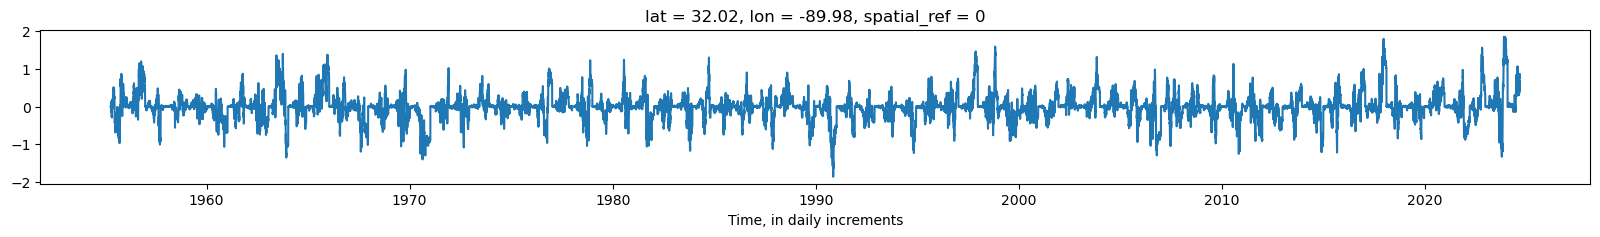

In [21]:
(claude_result-kbdi.__xarray_dataarray_variable__).plot(figsize=(20,2))

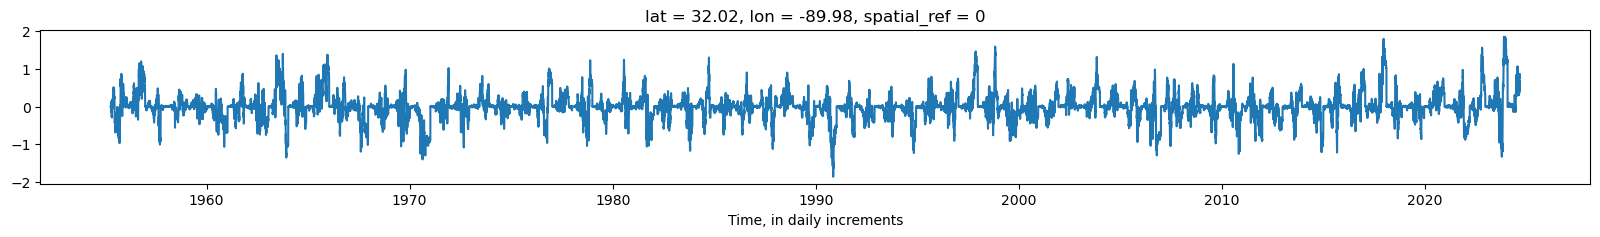

In [22]:
(claude_result-KBDI.__xarray_dataarray_variable__).plot(figsize=(20,2))

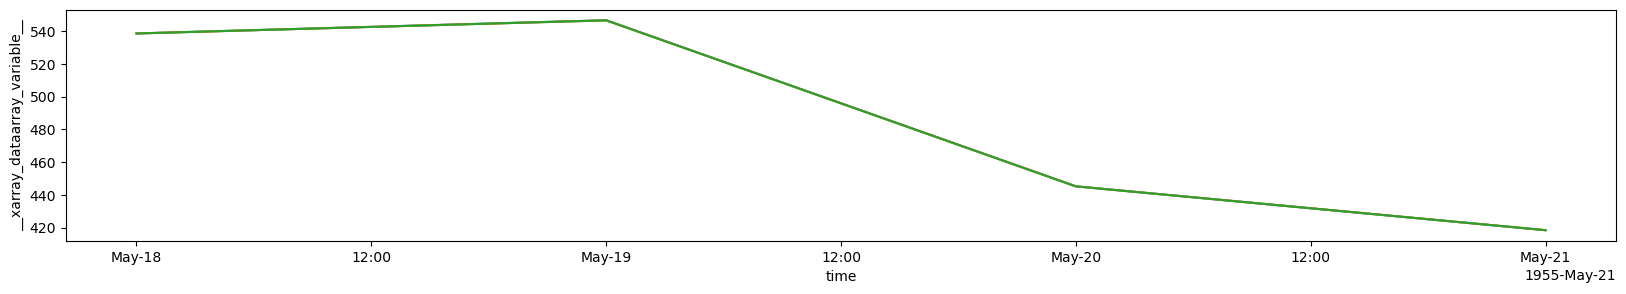

In [23]:
it1=1598
it2=1602
fig=plt.figure(figsize=(20,3))
claude_result.isel(time=slice(it1,it2)).plot()
KBDI.__xarray_dataarray_variable__.isel(time=slice(it1,it2)).plot()
kbdi.__xarray_dataarray_variable__.isel(time=slice(it1,it2)).plot()
plt.show()


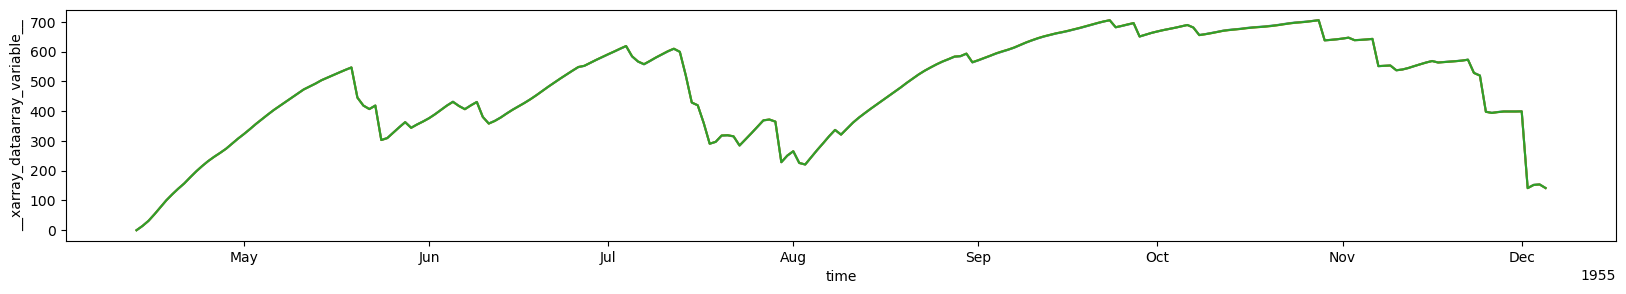

In [24]:
it1=0
it2=1800
fig=plt.figure(figsize=(20,3))
claude_result.isel(time=slice(it1,it2)).plot()
KBDI.__xarray_dataarray_variable__.isel(time=slice(it1,it2)).plot()
kbdi.__xarray_dataarray_variable__.isel(time=slice(it1,it2)).plot()
plt.show()

In [ ]:
pnet

In [17]:
# modified Claude code that matches single grid code
# runs a little slower 15s for 2300 grids

@jit(nopython=True)
def _calc_pnet_consecutive_numba(pr_data, cat_data, acc_thresh=0.2):
    """Numba-optimized function to calculate Pnet for consecutive rain days."""
    pnet = pr_data.copy()
    n_time = len(pr_data)
    
    # Find consecutive rain day indices
    consec_inds = []
    for i in range(n_time):
        if cat_data[i] == 2:
            consec_inds.append(i)
    
    # Process consecutive rain events
    i = 0
    while i < len(consec_inds):
        # Find the end of current consecutive event
        event_start = i
        while i < len(consec_inds) - 1 and consec_inds[i+1] == consec_inds[i] + 1:
            i += 1
        event_end = i
        
        # Process this consecutive rain event
        accpr = np.float32(0)
        thresh_flag = False
        
        for j in range(event_start, event_end + 1):
            ind = consec_inds[j]
            accpr += pr_data[ind]
            
            if accpr <= acc_thresh and not thresh_flag:
                pnet[ind] = np.float32(0)
            elif accpr > acc_thresh and not thresh_flag:
                accpr -= acc_thresh
                pnet[ind] = accpr
                thresh_flag = True
            else:
                pnet[ind] = pr_data[ind]
        
        i += 1
    
    return pnet

@jit(nopython=True)
def _calc_kbdi_timeseries_numba(T_data, pnet_data, mean_ann_pr, day_int):
    """Numba-optimized KBDI time series calculation."""
    n_time = len(T_data)
    KBDI = np.full(n_time, np.float32(np.nan))
    
    if day_int >= 0 and day_int < n_time:
        KBDI[day_int] = np.float32(0)
        
        denominator = np.float32(1 + 10.88 * np.exp(-0.0441 * mean_ann_pr))
        
        for it in range(day_int + 1, n_time):
            Q = max(np.float32(0), KBDI[it-1] - pnet_data[it] * np.float32(100))
            numerator = np.float32((800 - Q) * (0.968 * np.exp(0.0486 * T_data[it]) - 8.3))
            KBDI[it] = Q + (numerator / denominator) * np.float32(1e-3)
    
    return KBDI

def calc_kbdi_vectorized(T, PR):
    """
    Vectorized KBDI calculation for multiple grid points.
    
    Parameters:
    -----------
    T : xarray.DataArray
        Temperature data with dimensions (time, lat, lon) in Fahrenheit
    PR : xarray.DataArray  
        Precipitation data with dimensions (time, lat, lon) in inches
    
    Returns:
    --------
    KBDI : xarray.DataArray
        KBDI values with same dimensions as input
    """
    
    # Create land mask - only calculate where we have finite precipitation
    landmask = np.isfinite(PR.mean('time'))
    
    # Create time index
    time_index = np.arange(len(PR.time)).astype('int')
    PR = PR.assign_coords(time_index=('time', time_index))
    T = T.assign_coords(time_index=('time', time_index))
    
    # Parameters
    ndays = 7
    pr_thresh = 8  # inches
    acc_thresh = 0.2  # inches
    
    # Calculate 7-day rolling precipitation sum
    pr_weeksum = PR.rolling(time=ndays, min_periods=ndays, center=False).sum()
    
    # Find saturation days (vectorized across space)
    def find_first_saturation_day(pr_week_1d):
        """Find first day where weekly precip exceeds threshold."""
        if np.isnan(pr_week_1d).all():
            return -1
        
        exceeds = pr_week_1d > pr_thresh
        if not exceeds.any():
            return -1
        
        return int(np.argmax(exceeds))
    
    # Apply across lat/lon dimensions
    saturation_days = xr.apply_ufunc(
        find_first_saturation_day,
        pr_weeksum,
        input_core_dims=[['time']],
        output_dtypes=[int],
        vectorize=True,
        dask='parallelized'
    )
    
    # Calculate consecutive rain days (vectorized)
    rainmask = xr.where(PR > 0, 1, 0).astype('int8')
    temp=rainmask.cumsum('time').astype('int8')
    rr = temp - temp.where(rainmask == 0).ffill(dim='time').fillna(0).astype('int8')

    # Calculate mean annual precipitation
    years = pd.to_datetime(PR.time.values).year
    PR_with_year = PR.assign_coords(year=('time', years))
    annual_sums = PR_with_year.groupby('year').sum(min_count=360)
    mean_ann_pr = annual_sums.mean('year')
    
    # Define function to process a single grid point
    def process_single_point(pr_1d, t_1d, rr_1d, mean_ann_pr_val, sat_day):
        """Process KBDI for a single lat/lon point."""
        if np.isnan(mean_ann_pr_val) or sat_day < 0:
            return np.full(len(pr_1d), np.nan) 

        # Calculate rainfall category 
        cat_1d = np.where(rr_1d >= 3, 5, rr_1d)
        # find the indexes of all second consecutive rainfall days
        consec_day2 = np.where(rr_1d == 2)
        consec_day2 = [arr.astype('int32') for arr in consec_day2]
        # find the indexes of all the first consecutive rainfall days
        consec_day1 = [arr-1 for arr in consec_day2]
        # label all consecutive rainfall days with a 2 
        cat_1d[consec_day2] = 5 # first put a 5
        cat_1d[consec_day1] = 5 # first put a 5
        cat_1d = np.where(cat_1d == 5, 2, cat_1d) # convert to 2's
    
        
        # Calculate Pnet for consecutive rain days
        pnet_1d = _calc_pnet_consecutive_numba(
            pr_1d.astype(np.float64), 
            cat_1d.astype(np.int32), 
            acc_thresh
        )
        
        # Apply single rain day adjustment
        single_mask = (cat_1d == 1)
        pnet_1d = np.where(single_mask, np.maximum(0, pnet_1d - acc_thresh), pnet_1d)
        
        # Calculate KBDI time series
        kbdi_1d = _calc_kbdi_timeseries_numba(
            t_1d.astype(np.float64),
            pnet_1d.astype(np.float64),
            float(mean_ann_pr_val),
            int(sat_day)
        )
        
        return kbdi_1d
    
    # Apply the function across all grid points
    KBDI = xr.apply_ufunc(
        process_single_point,
        PR.swap_dims({'time': 'time_index'}),
        T.swap_dims({'time': 'time_index'}),
        rr.swap_dims({'time': 'time_index'}),
        mean_ann_pr,
        saturation_days,
        input_core_dims=[['time_index'], ['time_index'], ['time_index'], [], []],
        output_core_dims=[['time_index']],
        output_dtypes=[float],
        vectorize=True,
        dask='parallelized'
    )
    
    # Convert back to original time coordinate
    KBDI = KBDI.swap_dims({'time_index': 'time'})
    KBDI = KBDI.assign_coords(time=PR.time)

    # return PNET
    return KBDI

def calc_kbdi_parallel_chunked(T, PR, chunks=None):
    """
    Parallel chunked version of KBDI calculation using Dask.
    
    Parameters:
    -----------
    T : xarray.DataArray
        Temperature data with dimensions (time, lat, lon) - will be converted to Fahrenheit
    PR : xarray.DataArray  
        Precipitation data with dimensions (time, lat, lon) - will be converted to inches
    chunks : dict, optional
        Chunk sizes for dask arrays, e.g., {'lat': 10, 'lon': 10, 'time': -1}
    
    Returns:
    --------
    KBDI : xarray.DataArray
        KBDI values with same dimensions as input
    """
    
    if chunks is None:
        # Default chunking strategy
        chunks = {'lat': min(20, T.sizes['lat']), 
                  'lon': min(20, T.sizes['lon']), 
                  'time': -1}  # Keep time together
    
    # Chunk the input data FIRST
    T_chunked = T.chunk(chunks)
    PR_chunked = PR.chunk(chunks)
    
    # THEN apply unit conversions (done in parallel by Dask)
    T_chunked = (T_chunked * 9/5) + 32  # Convert to Fahrenheit
    T_chunked.attrs = {'standard_name': 'air_temperature',
                       'long_name': 'Temperature, daily maximum',
                       'units': 'F'}
    
    PR_chunked = PR_chunked / 25.4  # Convert to inches
    PR_chunked.attrs = {'standard_name': 'precipitation', 
                        'long_name': 'Precipitation, daily total', 
                        'units': 'inches/day'}
    
    # Apply the vectorized calculation
    KBDI = calc_kbdi_vectorized(T_chunked, PR_chunked)
    # CAT = calc_kbdi_vectorized(T_chunked, PR_chunked)
    
    return KBDI

In [18]:
%%time

pr_file = r'D://data/nclimgrid_daily/prcp_nClimGridDaily_1951-2024_USsouth.nc'
tmax_file = r'D://data/nclimgrid_daily/tmax_nClimGridDaily_1951-2024_USsouth.nc'

year_start='1951'
year_end='2024'
lat1, lat2 = 32, 34
lon1, lon2 = -90, -88

# Load the full spatial domain you want to process:
pr = xr.open_dataset(pr_file).prcp.sel(time=slice(year_start,year_end),lat=slice(lat1,lat2), lon=slice(lon1,lon2))
tmax = xr.open_dataset(tmax_file).tmax.sel(time=slice(year_start,year_end),lat=slice(lat1,lat2), lon=slice(lon1,lon2)) 

# Then use the optimized function:
chunks = {'lat': 24, 'lon': 24, 'time': -1}  # Adjust based on your memory
kbdi_result = calc_kbdi_parallel_chunked(tmax, pr, chunks=chunks)
kbdi_result = kbdi_result.compute()  # Trigger computation

CPU times: total: 24.6 s
Wall time: 14.5 s


In [19]:
kbdi_result.sel(time_index=slice(0,30)).sel(lat=32,lon=-90,method='nearest').plot()


KeyError: "no index found for coordinate 'time_index'"

In [61]:
## THIS VERSION WORKS AND TAKES ~15s FOR 48x48 GRID

import xarray as xr
import numpy as np
import pandas as pd
from numba import jit
import dask
import dask.array as da
import matplotlib.pyplot as plt


@jit(nopython=True)
def _calc_pnet_consecutive_numba(pr_data, cat_data, acc_thresh=0.2):
    """Numba-optimized function to calculate Pnet for consecutive rain days."""
    pnet = pr_data.copy()
    n_time = len(pr_data)
    
    # Find consecutive rain day indices - more efficient approach
    i = 0
    while i < n_time:
        if cat_data[i] == 2:
            # Found start of consecutive rain event
            event_start = i
            # Find end of consecutive event
            while i < n_time and cat_data[i] == 2:
                i += 1
            event_end = i - 1
            
            # Process this consecutive rain event
            accpr = np.float32(0)
            thresh_flag = False
            
            for j in range(event_start, event_end + 1):
                accpr += pr_data[j]
                
                if accpr <= acc_thresh and not thresh_flag:
                    pnet[j] = np.float32(0)
                elif accpr > acc_thresh and not thresh_flag:
                    accpr -= acc_thresh
                    pnet[j] = accpr
                    thresh_flag = True
                else:
                    pnet[j] = pr_data[j]
        else:
            i += 1
    
    return pnet


@jit(nopython=True)
def _calc_kbdi_timeseries_numba(T_data, pnet_data, mean_ann_pr, day_int):
    """Numba-optimized KBDI time series calculation."""
    n_time = len(T_data)
    KBDI = np.full(n_time, np.float32(np.nan))
    
    if day_int >= 0 and day_int < n_time:
        KBDI[day_int] = np.float32(0)
        
        # Pre-calculate constant denominator
        denominator = np.float32(1 + 10.88 * np.exp(-0.0441 * mean_ann_pr))
        inv_denominator = np.float32(1e-3) / denominator  # Pre-calculate division
        
        for it in range(day_int + 1, n_time):
            Q = max(np.float32(0), KBDI[it-1] - pnet_data[it] *np.float32(100))
            numerator = np.float32((800 - Q) * (0.968 * np.exp(0.0486 * T_data[it]) - 8.3))
            KBDI[it] = Q + numerator * inv_denominator
    
    return KBDI


@jit(nopython=True)
def _calculate_consecutive_rain_categories_numba(rainmask):
    """Optimized calculation of consecutive rain day categories."""
    n_time = len(rainmask)
    cat_data = np.zeros(n_time, dtype=np.int8)
    
    i = 0
    while i < n_time:
        if rainmask[i] > 0:
            # Found start of rain event
            event_start = i
            event_length = 0
            
            # Count consecutive rain days
            while i < n_time and rainmask[i] > 0:
                event_length += 1
                i += 1
            
            # Assign categories based on event length
            if event_length == 1:
                cat_data[event_start] = 1  # Single rain day
            else:
                # Multiple consecutive rain days
                for j in range(event_start, event_start + event_length):
                    cat_data[j] = 2
        else:
            i += 1
    
    return cat_data


def calc_kbdi_vectorized_optimized(T, PR):
    """
    Optimized vectorized KBDI calculation for multiple grid points.
    
    Parameters:
    -----------
    T : xarray.DataArray
        Temperature data with dimensions (time, lat, lon) in Fahrenheit
    PR : xarray.DataArray  
        Precipitation data with dimensions (time, lat, lon) in inches
    
    Returns:
    --------
    KBDI : xarray.DataArray
        KBDI values with same dimensions as input
    """
    # Create time index
    time_index = np.arange(len(PR.time), dtype=np.int32)
    PR = PR.assign_coords(time_index=('time', time_index))
    T = T.assign_coords(time_index=('time', time_index))
    
    # Parameters
    ndays = np.int8(7)
    pr_thresh = np.float32(8.0)  # inches
    acc_thresh = np.float32(0.2)  # inches
    

    # LAZY CALCULATIONS ON CHUNKED XARRAY (DASK) ARRAYS

    # Calculate 7-day rolling precipitation sum - more efficient
    pr_weeksum = PR.rolling(time=ndays, min_periods=ndays, center=False).sum('time')

    # Calculate mean annual precipitation
    mean_ann_pr = PR.groupby('time.year').sum(min_count=360).mean('year')
    
    # GRID-BY-GRID CALCULATIONS
    # VECTORIZED AND PARALLELIZED WITH XARRAY APPLY_UFUNC AND DASK
    # OPTIMIZED WITH NUMBA
    
    # Optimized saturation day finding
    def find_first_saturation_day_optimized(pr_week_1d):
        """Optimized version using numpy operations."""
        valid_mask = ~np.isnan(pr_week_1d)
        if not valid_mask.any():
            return -1
        
        exceeds = pr_week_1d > pr_thresh
        if not exceeds.any():
            return -1
        
        return int(np.argmax(exceeds))
    
    # Apply across lat/lon dimensions
    saturation_days = xr.apply_ufunc(
        find_first_saturation_day_optimized,
        pr_weeksum,
        input_core_dims=[['time']],
        output_dtypes=[np.int32],
        vectorize=True,
        dask='parallelized')

    # Define optimized function to process a single grid point
    def process_single_point_optimized(pr_1d, t_1d, mean_ann_pr_val, sat_day):
        """Optimized processing for a single lat/lon point."""
        if np.isnan(mean_ann_pr_val) or sat_day < 0:
            return np.full(len(pr_1d), np.float32(np.nan))

        # Create rain mask (0 or 1) - more efficient
        rainmask = (pr_1d > 0).astype(np.int8)
        
        # Calculate rainfall categories using optimized numba function
        cat_1d = _calculate_consecutive_rain_categories_numba(rainmask)
        
        # Calculate Pnet for consecutive rain days
        pnet_1d = _calc_pnet_consecutive_numba(
            pr_1d, 
            cat_1d, 
            acc_thresh)
        
        # Apply single rain day adjustment - vectorized
        single_mask = (cat_1d == 1)
        pnet_1d = np.where(single_mask, np.maximum(np.float32(0), pnet_1d - acc_thresh), pnet_1d)
        
        # Calculate KBDI time series
        kbdi_1d = _calc_kbdi_timeseries_numba(
            t_1d,
            pnet_1d,
            mean_ann_pr_val,
            sat_day)
        
        return kbdi_1d
    
    # Apply the function across all grid points
    KBDI = xr.apply_ufunc(
        process_single_point_optimized,
        PR.swap_dims({'time': 'time_index'}),
        T.swap_dims({'time': 'time_index'}),
        mean_ann_pr,
        saturation_days,
        input_core_dims=[['time_index'], ['time_index'], [], []],
        output_core_dims=[['time_index']],
        output_dtypes=[np.float32],
        vectorize=True,
        dask='parallelized'
    )
    
    # Convert back to original time coordinate
    KBDI = KBDI.swap_dims({'time_index': 'time'})
    KBDI = KBDI.assign_coords(time=PR.time)

    return KBDI


def calc_kbdi_parallel_chunked_optimized(T, PR, chunks=None):
    """
    Optimized parallel chunked version of KBDI calculation using Dask.
    
    Parameters:
    -----------
    T : xarray.DataArray
        Temperature data with dimensions (time, lat, lon) - will be converted to Fahrenheit
    PR : xarray.DataArray  
        Precipitation data with dimensions (time, lat, lon) - will be converted to inches
    chunks : dict, optional
        Chunk sizes for dask arrays, e.g., {'lat': 10, 'lon': 10, 'time': -1}
    
    Returns:
    --------
    KBDI : xarray.DataArray
        KBDI values with same dimensions as input
    """
    
    if chunks is None:
        # Optimized default chunking strategy
        chunks = {'lat': min(32, T.sizes['lat']), 
                  'lon': min(32, T.sizes['lon']), 
                  'time': -1}  # Keep time together
    
    # Chunk the input data FIRST
    T_chunked = T.chunk(chunks)
    PR_chunked = PR.chunk(chunks)
    
    # Apply precision limit and unit conversions in parallel
    T_chunked = T_chunked.round(2).astype('float32')  # round to 2 decimal places
    T_chunked = T_chunked * np.float32(9/5) + np.float32(32.0)  # Convert to Fahrenheit 
    T_chunked.attrs = {'standard_name': 'air_temperature',
                       'long_name': 'Temperature, daily maximum',
                       'units': 'F'}

    PR_chunked = PR_chunked.round(2).astype('float32')
    PR_chunked = PR_chunked * np.float32(1/25.4)  # Convert to inches - optimized
    PR_chunked.attrs = {'standard_name': 'precipitation', 
                        'long_name': 'Precipitation, daily total', 
                        'units': 'inches/day'}
    
    # Apply the optimized vectorized calculation
    KBDI = calc_kbdi_vectorized_optimized(T_chunked, PR_chunked)
    
    return KBDI


In [70]:
%%time
pr_file = r'D://data/nclimgrid_daily/prcp_nClimGridDaily_1951-2024_USsouth.nc'
tmax_file = r'D://data/nclimgrid_daily/tmax_nClimGridDaily_1951-2024_USsouth.nc'

year_start = '1951'
year_end = '2024'
lat1, lat2 = 32, 34
lon1, lon2 = -90, -88

# Load data with optimized settings
with xr.open_dataset(pr_file) as ds_pr:
    pr = ds_pr.prcp.sel(time=slice(year_start, year_end), 
                       lat=slice(lat1, lat2), 
                       lon=slice(lon1, lon2))

with xr.open_dataset(tmax_file) as ds_tmax:
    tmax = ds_tmax.tmax.sel(time=slice(year_start, year_end), 
                           lat=slice(lat1, lat2), 
                           lon=slice(lon1, lon2))

# More aggressive chunking for better parallelization
chunks = {'lat': 24, 'lon': 24, 'time': -1}  # Smaller chunks = more parallel tasks

# Run optimized calculation
kbdi_result = calc_kbdi_parallel_chunked_optimized(tmax, pr, chunks=chunks)
kbdi_result = kbdi_result.compute()  # Trigger computation


Frozen({'time': 26907, 'lat': 48, 'lon': 48})

In [45]:
claude_result = kbdi_result.sel(lat=32,lon=-90,method='nearest')
KBDI = xr.open_dataset('KBDI.nc')
kbdi = xr.open_dataset('kbdi.nc')
# KBDI

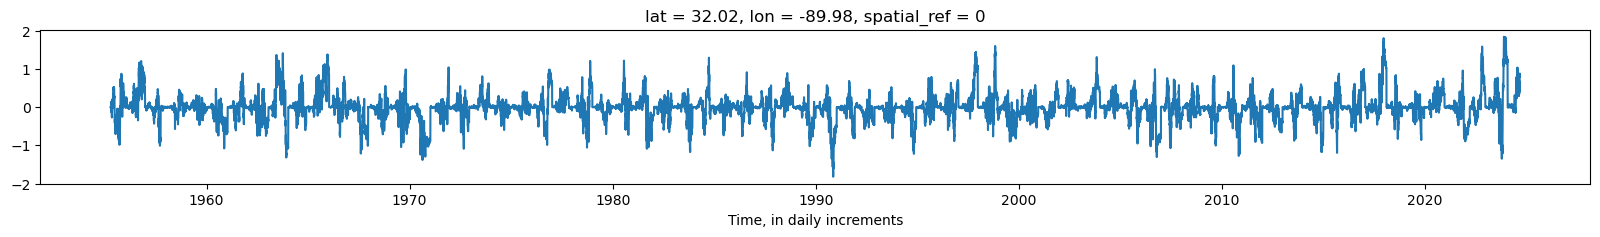

In [46]:
(claude_result-kbdi.__xarray_dataarray_variable__).plot(figsize=(20,2))

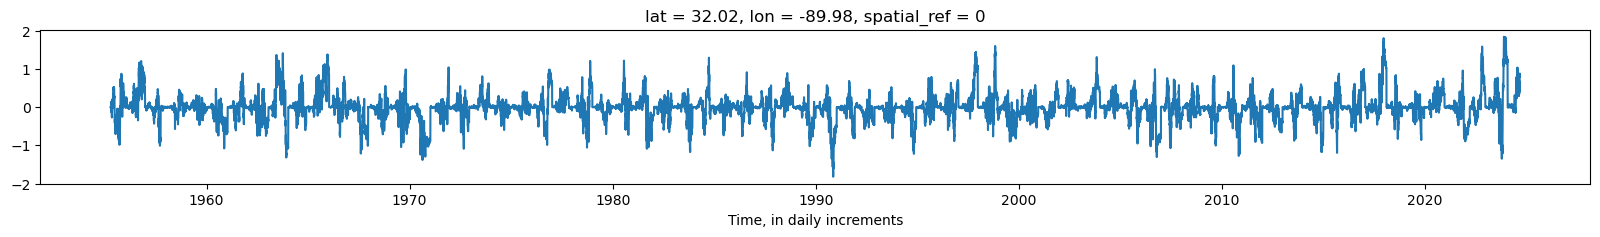

In [47]:
(claude_result-KBDI.__xarray_dataarray_variable__).plot(figsize=(20,2))

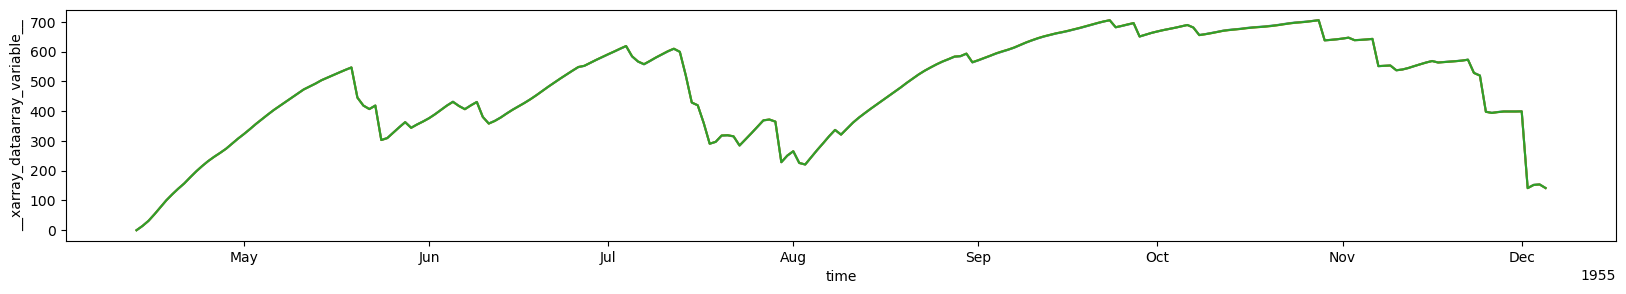

In [37]:
it1=0
it2=1800
fig=plt.figure(figsize=(20,3))
claude_result.isel(time=slice(it1,it2)).plot()
KBDI.__xarray_dataarray_variable__.isel(time=slice(it1,it2)).plot()
kbdi.__xarray_dataarray_variable__.isel(time=slice(it1,it2)).plot()
plt.show()

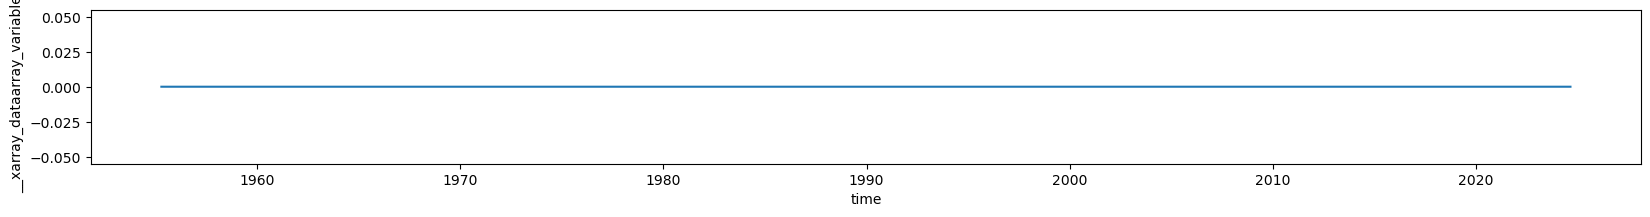

In [48]:
(kbdi.__xarray_dataarray_variable__-KBDI.__xarray_dataarray_variable__).plot(figsize=(20,2))

In [75]:
import xarray as xr
import numpy as np
import pandas as pd
from numba import jit
import dask
import dask.array as da
import matplotlib.pyplot as plt


@jit(nopython=True, fastmath=True, cache=True)
def _calc_pnet_consecutive_numba(pr_data, cat_data, acc_thresh=0.2):
    """Numba-optimized function to calculate Pnet for consecutive rain days."""
    pnet = pr_data.copy()
    n_time = len(pr_data)
    
    # Find consecutive rain day indices - more efficient approach
    i = 0
    while i < n_time:
        if cat_data[i] == 2:
            # Found start of consecutive rain event
            event_start = i
            # Find end of consecutive event
            while i < n_time and cat_data[i] == 2:
                i += 1
            event_end = i - 1
            
            # Process this consecutive rain event
            accpr = np.float32(0)
            thresh_flag = False
            
            for j in range(event_start, event_end + 1):
                accpr += pr_data[j]
                
                if accpr <= acc_thresh and not thresh_flag:
                    pnet[j] = np.float32(0)
                elif accpr > acc_thresh and not thresh_flag:
                    accpr -= acc_thresh
                    pnet[j] = accpr
                    thresh_flag = True
                else:
                    pnet[j] = pr_data[j]
        else:
            i += 1
    
    return pnet


@jit(nopython=True, fastmath=True, cache=True)
def _calc_kbdi_timeseries_numba(T_data, pnet_data, mean_ann_pr, day_int):
    """Numba-optimized KBDI time series calculation."""
    n_time = len(T_data)
    KBDI = np.full(n_time, np.float32(np.nan))
    
    if day_int >= 0 and day_int < n_time:
        KBDI[day_int] = np.float32(0)
        
        # Pre-calculate constant denominator
        denominator = np.float32(1 + 10.88 * np.exp(-0.0441 * mean_ann_pr))
        inv_denominator = np.float32(1e-3) / denominator  # Pre-calculate division
        
        for it in range(day_int + 1, n_time):
            Q = max(np.float32(0), KBDI[it-1] - pnet_data[it] * np.float32(100))
            numerator = np.float32((800 - Q) * (0.968 * np.exp(0.0486 * T_data[it]) - 8.3))
            KBDI[it] = Q + numerator * inv_denominator
    
    return KBDI


@jit(nopython=True, fastmath=True, cache=True)
def _calculate_consecutive_rain_categories_numba(rainmask):
    """Optimized calculation of consecutive rain day categories."""
    n_time = len(rainmask)
    cat_data = np.zeros(n_time, dtype=np.int8)
    
    i = 0
    while i < n_time:
        if rainmask[i] > 0:
            # Found start of rain event
            event_start = i
            event_length = 0
            
            # Count consecutive rain days
            while i < n_time and rainmask[i] > 0:
                event_length += 1
                i += 1
            
            # Assign categories based on event length
            if event_length == 1:
                cat_data[event_start] = 1  # Single rain day
            else:
                # Multiple consecutive rain days
                for j in range(event_start, event_start + event_length):
                    cat_data[j] = 2
        else:
            i += 1
    
    return cat_data


def calc_kbdi_vectorized_optimized(T, PR):
    """
    Optimized vectorized KBDI calculation for multiple grid points.
    
    Parameters:
    -----------
    T : xarray.DataArray
        Temperature data with dimensions (time, lat, lon) in Fahrenheit
    PR : xarray.DataArray  
        Precipitation data with dimensions (time, lat, lon) in inches
    
    Returns:
    --------
    KBDI : xarray.DataArray
        KBDI values with same dimensions as input
    """
    # Create time index
    time_index = np.arange(len(PR.time), dtype=np.int32)
    PR = PR.assign_coords(time_index=('time', time_index))
    T = T.assign_coords(time_index=('time', time_index))
    
    # Parameters
    ndays = np.int8(7)
    pr_thresh = np.float32(8.0)  # inches
    acc_thresh = np.float32(0.2)  # inches
    
    # LAZY CALCULATIONS ON CHUNKED XARRAY (DASK) ARRAYS
    # Calculate 7-day rolling precipitation sum - more efficient
    pr_weeksum = PR.rolling(time=ndays, min_periods=ndays, center=False).sum('time')

    # Calculate mean annual precipitation - optimized groupby
    mean_ann_pr = PR.resample(time='YE').sum(min_count=360).mean('time')
    
    # GRID-BY-GRID CALCULATIONS
    # VECTORIZED AND PARALLELIZED WITH XARRAY APPLY_UFUNC AND DASK
    # OPTIMIZED WITH NUMBA
    
    # Optimized saturation day finding
    @jit(nopython=True, fastmath=True, cache=True)
    def find_first_saturation_day_optimized(pr_week_1d, pr_thresh=8.0):
        """Optimized version using numba."""
        n_time = len(pr_week_1d)
        for i in range(n_time):
            if not np.isnan(pr_week_1d[i]) and pr_week_1d[i] > pr_thresh:
                return np.int32(i)
        return np.int32(-1)
    
    # Apply across lat/lon dimensions
    saturation_days = xr.apply_ufunc(
        find_first_saturation_day_optimized,
        pr_weeksum,
        input_core_dims=[['time']],
        output_dtypes=[np.int32],
        vectorize=True,
        dask='parallelized')

    # Define optimized function to process a single grid point
    @jit(nopython=True, fastmath=True, cache=True)
    def process_single_point_optimized(pr_1d, t_1d, mean_ann_pr_val, sat_day, acc_thresh=0.2):
        """Optimized processing for a single lat/lon point."""
        if np.isnan(mean_ann_pr_val) or sat_day < 0:
            return np.full(len(pr_1d), np.float32(np.nan))

        # Create rain mask (0 or 1) - more efficient
        n_time = len(pr_1d)
        rainmask = np.zeros(n_time, dtype=np.int8)
        for i in range(n_time):
            if pr_1d[i] > 0:
                rainmask[i] = 1
        
        # Calculate rainfall categories using optimized numba function
        cat_1d = _calculate_consecutive_rain_categories_numba(rainmask)
        
        # Calculate Pnet for consecutive rain days
        pnet_1d = _calc_pnet_consecutive_numba(pr_1d, cat_1d, acc_thresh)
        
        # Apply single rain day adjustment - vectorized
        for i in range(n_time):
            if cat_1d[i] == 1:
                pnet_1d[i] = max(np.float32(0), pnet_1d[i] - acc_thresh)
        
        # Calculate KBDI time series
        kbdi_1d = _calc_kbdi_timeseries_numba(t_1d, pnet_1d, mean_ann_pr_val, sat_day)
        
        return kbdi_1d
    
    # Apply the function across all grid points
    KBDI = xr.apply_ufunc(
        process_single_point_optimized,
        PR.swap_dims({'time': 'time_index'}),
        T.swap_dims({'time': 'time_index'}),
        mean_ann_pr,
        saturation_days,
        input_core_dims=[['time_index'], ['time_index'], [], []],
        output_core_dims=[['time_index']],
        output_dtypes=[np.float32],
        vectorize=True,
        dask='parallelized'
    )
    
    # Convert back to original time coordinate
    KBDI = KBDI.swap_dims({'time_index': 'time'})
    KBDI = KBDI.assign_coords(time=PR.time)

    return KBDI


def calc_kbdi_parallel_chunked_optimized(T, PR, chunks=None):
    """
    Optimized parallel chunked version of KBDI calculation using Dask.
    
    Parameters:
    -----------
    T : xarray.DataArray
        Temperature data with dimensions (time, lat, lon) - will be converted to Fahrenheit
    PR : xarray.DataArray  
        Precipitation data with dimensions (time, lat, lon) - will be converted to inches
    chunks : dict, optional
        Chunk sizes for dask arrays, e.g., {'lat': 10, 'lon': 10, 'time': -1}
    
    Returns:
    --------
    KBDI : xarray.DataArray
        KBDI values with same dimensions as input
    """
    
    if chunks is None:
        # More aggressive chunking for large datasets
        lat_chunk = min(16, T.sizes['lat'])  # Smaller spatial chunks
        lon_chunk = min(16, T.sizes['lon'])
        chunks = {'lat': lat_chunk, 'lon': lon_chunk, 'time': -1}
    
    # Chunk the input data FIRST - smaller chunks for better parallelization
    T_chunked = T.chunk(chunks)
    PR_chunked = PR.chunk(chunks)
    
    # Apply precision limit and unit conversions in parallel
    T_chunked = (T_chunked * np.float32(9/5) + np.float32(32.0)).astype('float32')  # Convert to Fahrenheit 
    T_chunked.attrs = {'standard_name': 'air_temperature',
                       'long_name': 'Temperature, daily maximum',
                       'units': 'F'}

    PR_chunked = (PR_chunked * np.float32(1/25.4)).astype('float32')  # Convert to inches
    PR_chunked.attrs = {'standard_name': 'precipitation', 
                        'long_name': 'Precipitation, daily total', 
                        'units': 'inches/day'}
    
    # Apply the optimized vectorized calculation
    KBDI = calc_kbdi_vectorized_optimized(T_chunked, PR_chunked)
    
    return KBDI




In [77]:
%%time
# Example usage
pr_file = r'D://data/nclimgrid_daily/prcp_nClimGridDaily_1951-2024_USsouth.nc'
tmax_file = r'D://data/nclimgrid_daily/tmax_nClimGridDaily_1951-2024_USsouth.nc'

year_start = '1951'
year_end = '2024'
lat1, lat2 = 32, 34
lon1, lon2 = -90, -88

# Load data with optimized settings
with xr.open_dataset(pr_file) as ds_pr:
    pr = ds_pr.prcp.sel(time=slice(year_start, year_end), 
                       lat=slice(lat1, lat2), 
                       lon=slice(lon1, lon2))

with xr.open_dataset(tmax_file) as ds_tmax:
    tmax = ds_tmax.tmax.sel(time=slice(year_start, year_end), 
                           lat=slice(lat1, lat2), 
                           lon=slice(lon1, lon2))

# More aggressive chunking for better parallelization
chunks = {'lat': 24, 'lon': 24, 'time': -1}  # Smaller chunks = more parallel tasks

# Run optimized calculation
kbdi_result = calc_kbdi_parallel_chunked_optimized(tmax, pr, chunks=chunks)
kbdi_result = kbdi_result.compute()  # Trigger computation

CPU times: total: 12.8 s
Wall time: 8.84 s


In [78]:
claude_result = kbdi_result.sel(lat=32,lon=-90,method='nearest')
KBDI = xr.open_dataset('KBDI.nc')
kbdi = xr.open_dataset('kbdi.nc')
# KBDI

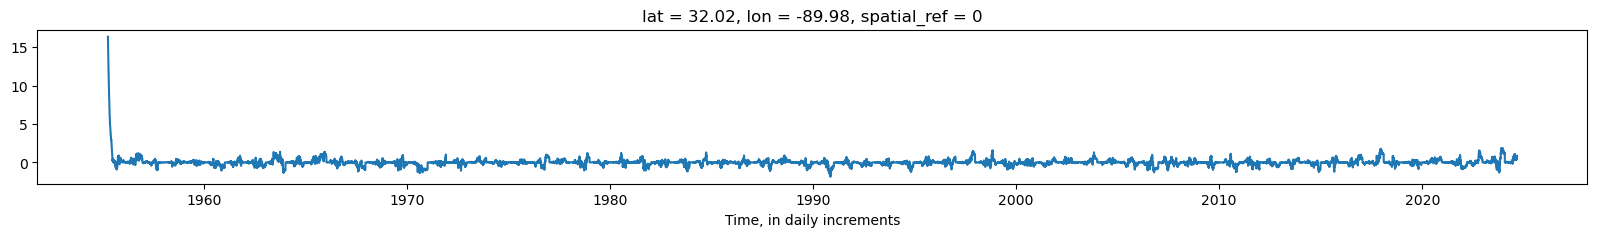

In [79]:
(claude_result-kbdi.__xarray_dataarray_variable__).plot(figsize=(20,2))